In [3]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
import dynchro

In [5]:
%load_ext autoreload
%autoreload 2

# 1. Data loading

In [6]:
adata = ad.read_h5ad("data/processed_wildtype.h5ad")
irf8 = ad.read_h5ad("data/processed_irf8.h5ad")
gfi1 = ad.read_h5ad("data/processed_gfi1.h5ad")
both = ad.read_h5ad("data/processed_both.h5ad")

In [7]:
lineages = {"erythrocytic": [2, 1], "monocytic": [2, 0, 4], "granulocytic": [2, 0, 3]}
adata, irf8, gfi1, both, lineages

(AnnData object with n_obs × n_vars = 382 × 500
     obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones'
     var: 'n_counts', 'n_cells', 'pct_cells'
     uns: 'branch_id_alias_colors', 'label_colors', 'lineages', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap',
 AnnData object with n_obs × n_vars = 62 × 500
     obs: 'label', 'pseudotime'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData object with n_obs × n_vars = 79 × 500
     obs: 'label', 'pseudotime'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData

# 2. Dynchro

## 2.1 Prep samples

In [8]:
# We prepare the dataset for dynchro analysis by labeling the lineages
adata.uns["id"] = "wildtype"
adata.uns["lineages"] = lineages
adata.obs["milestones"] = adata.obs["branch_id_id"]
for name, labels in lineages.items():
    adata = dynchro.pp.label_lineage(adata, "milestones", labels, name)
adata

AnnData object with n_obs × n_vars = 382 × 500
    obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones', 'erythrocytic', 'monocytic', 'granulocytic'
    var: 'n_counts', 'n_cells', 'pct_cells'
    uns: 'branch_id_alias_colors', 'label_colors', 'lineages', 'var_genes', 'workdir', 'id', 'lineage_labels'
    obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap'

In [ ]:
# Similarly, we prepare the knockouts as well
irf8.uns["id"] = "irf8"
gfi1.uns["id"] = "gfi1"
both.uns["id"] = "both"

for a in [irf8, gfi1, both]:
    a.uns["lineages"] = lineages
    a.obs["milestones"] = 1
    a = dynchro.pp.label_lineage(a, "milestones", [1], a.uns["id"])

irf8, gfi1, both

(AnnData object with n_obs × n_vars = 62 × 500
     obs: 'label', 'pseudotime', 'milestones', 'irf8'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData object with n_obs × n_vars = 79 × 500
     obs: 'label', 'pseudotime', 'milestones', 'gfi1'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData object with n_obs × n_vars = 47 × 500
     obs: 'label', 'pseudotime', 'milestones', 'both'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes')

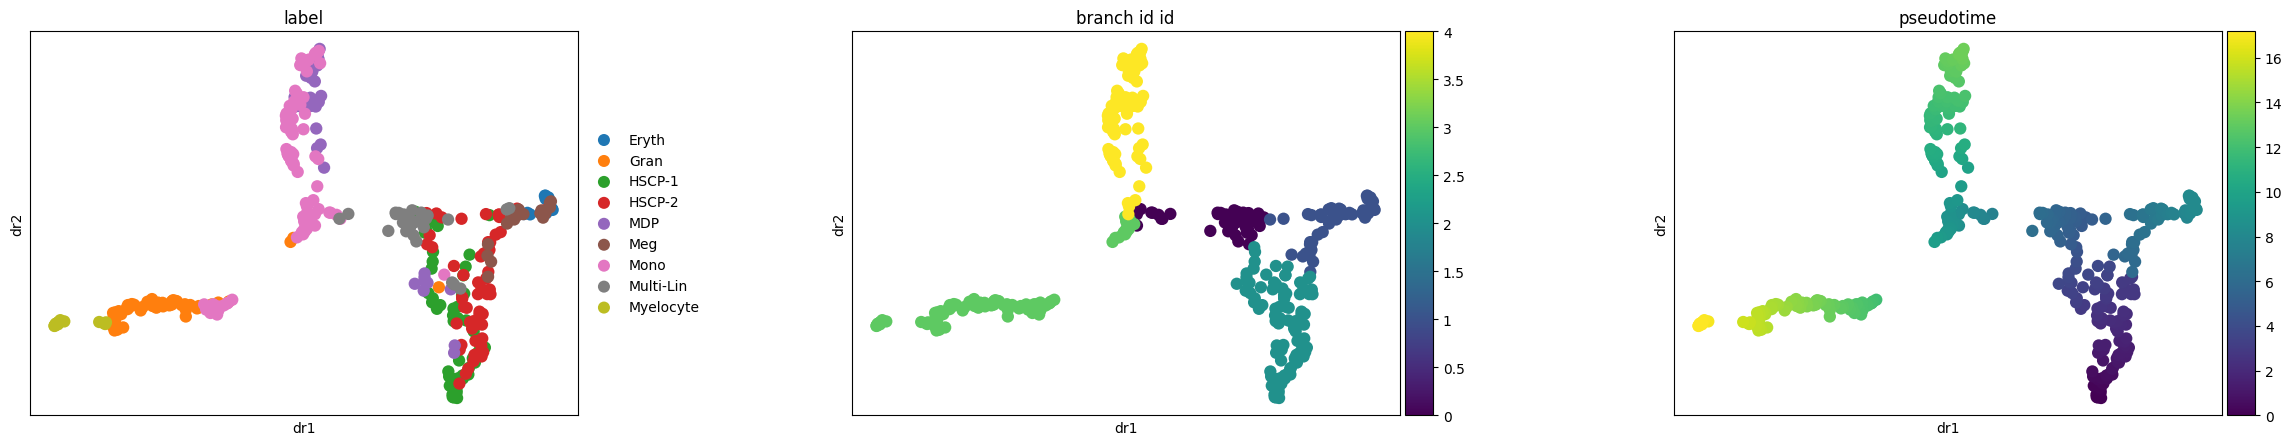

In [41]:
sc.pl.scatter(adata, color=['label', 'branch_id_id', 'pseudotime'], basis='dr')

In [42]:
adata.write_h5ad("figures/wildtype_start.h5ad")
irf8.write_h5ad("figures/irf8_start.h5ad")
gfi1.write_h5ad("figures/gfi1_start.h5ad")
both.write_h5ad("figures/both_start.h5ad")

## 2.2 Run dynchro

For each knockout, we will perform dynchro alignment to try and find the best matching lineages in the wildtype dataset.

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['irf8_erythrocytic_irf8_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:120: ImplicitModificationWarning: Setting element `.obsm['irf8_erythrocytic_irf8_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


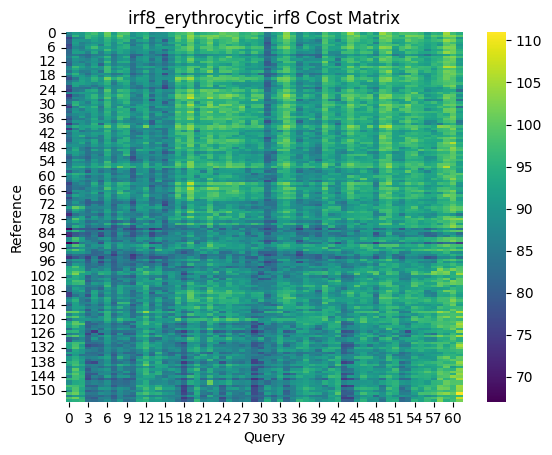

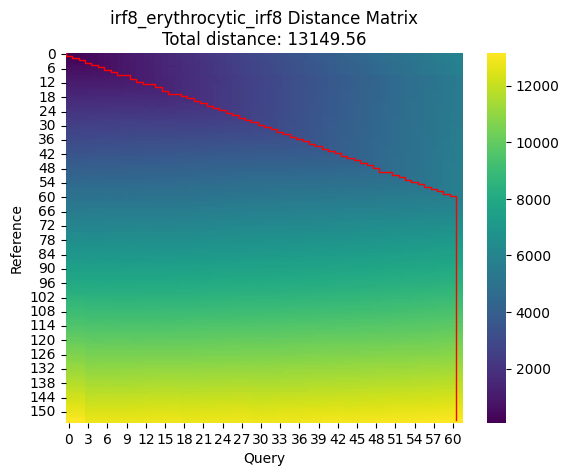

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['irf8_monocytic_irf8_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


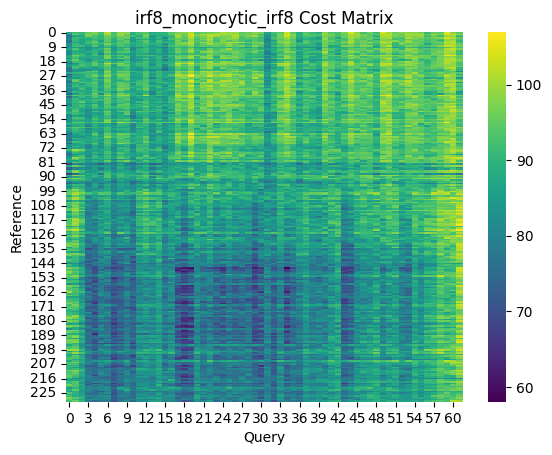

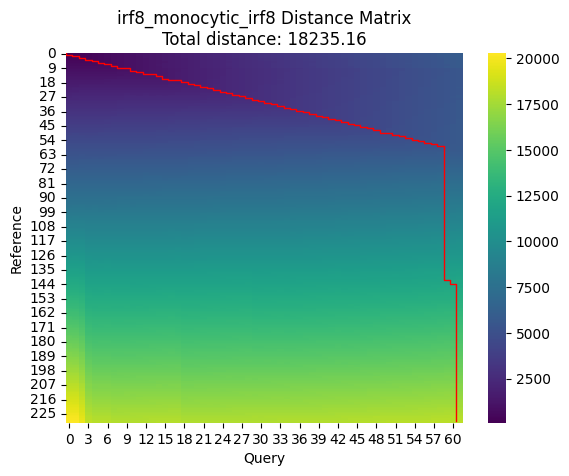

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['irf8_granulocytic_irf8_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


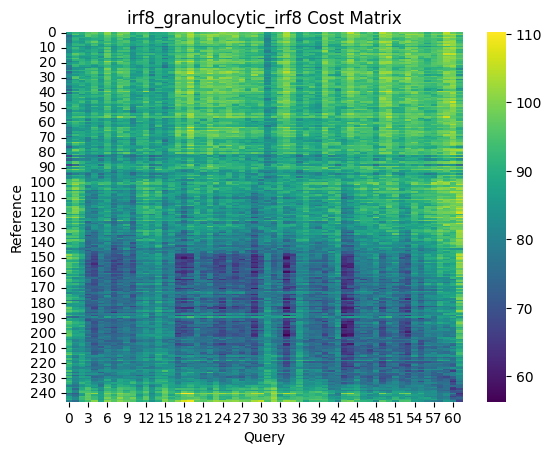

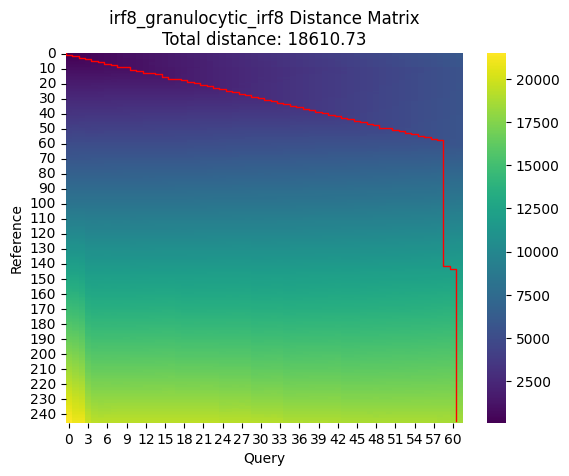

In [51]:
warping_irf8 = dynchro.tl.get_matching_lineages(adata, irf8, "irf8", mode = "copy", plot = True)

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['gfi1_erythrocytic_gfi1_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:120: ImplicitModificationWarning: Setting element `.obsm['gfi1_erythrocytic_gfi1_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


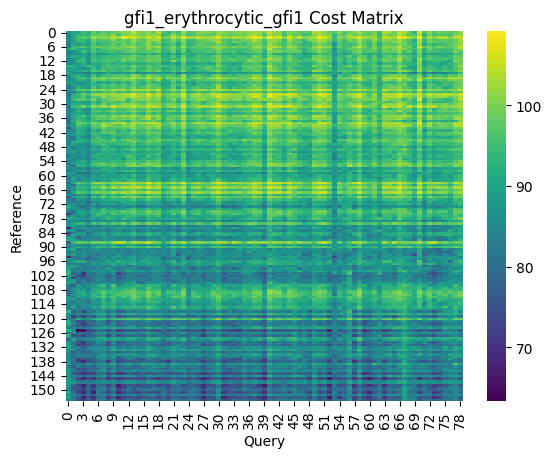

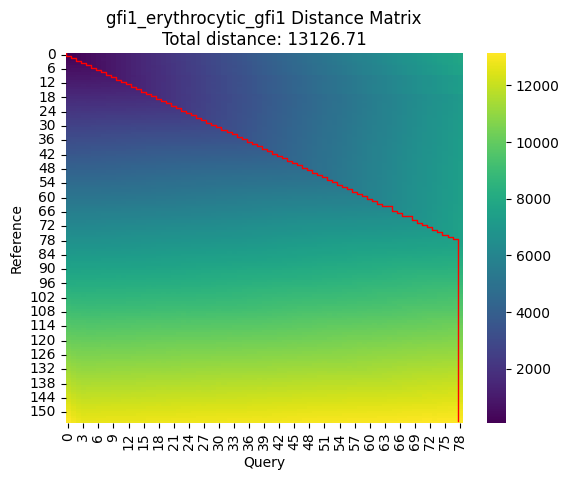

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['gfi1_monocytic_gfi1_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


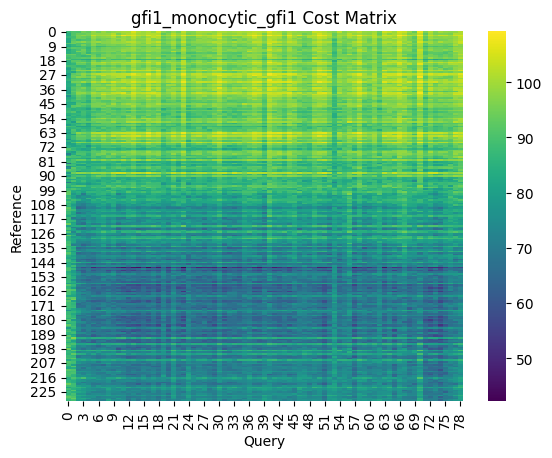

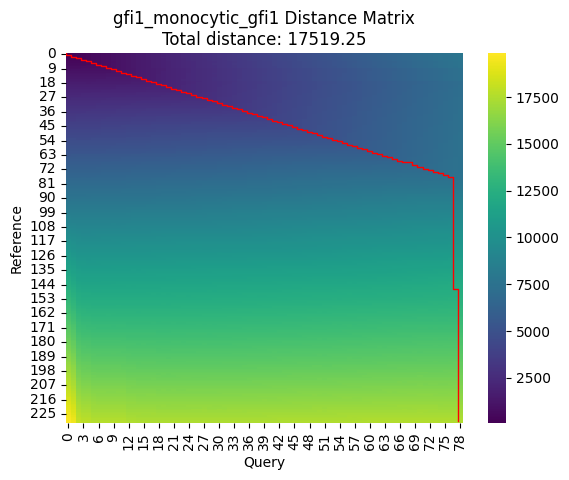

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['gfi1_granulocytic_gfi1_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


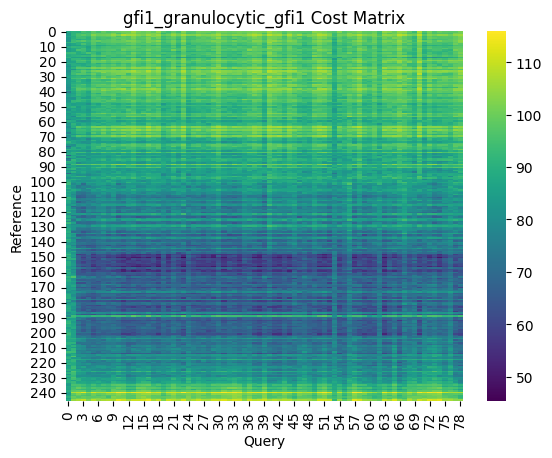

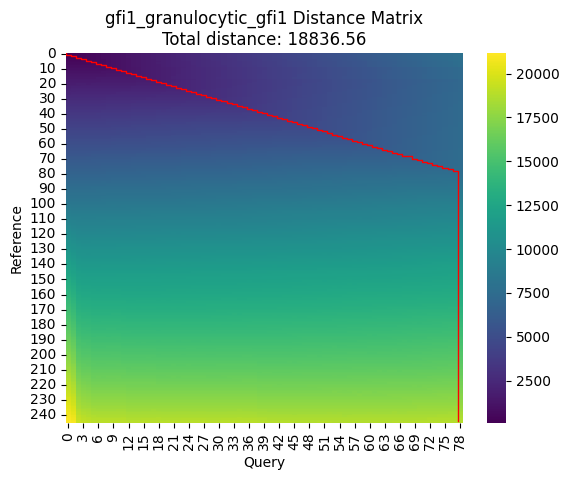

In [52]:
warping_gfi1 = dynchro.tl.get_matching_lineages(adata, gfi1, "gfi1", mode="copy", plot = True)

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['both_erythrocytic_both_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:120: ImplicitModificationWarning: Setting element `.obsm['both_erythrocytic_both_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


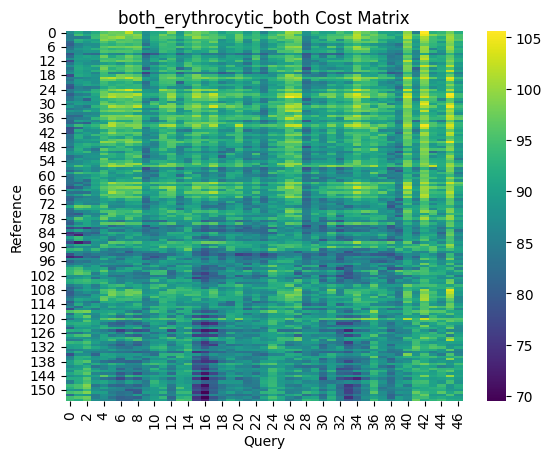

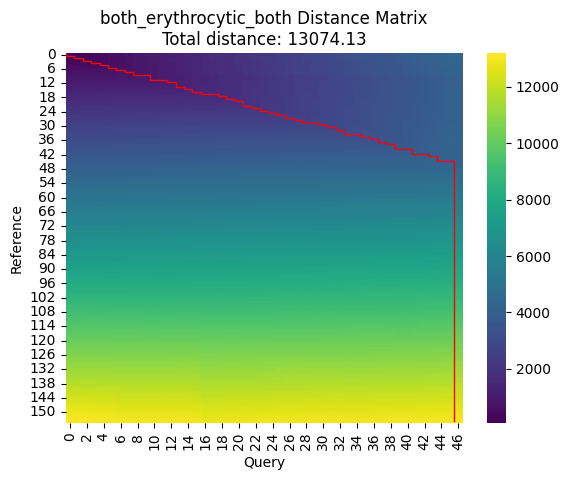

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['both_monocytic_both_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


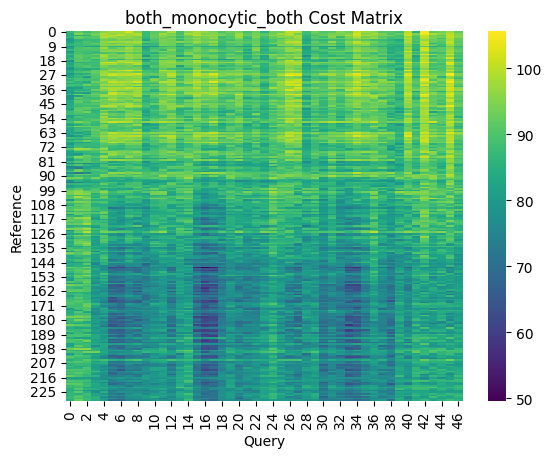

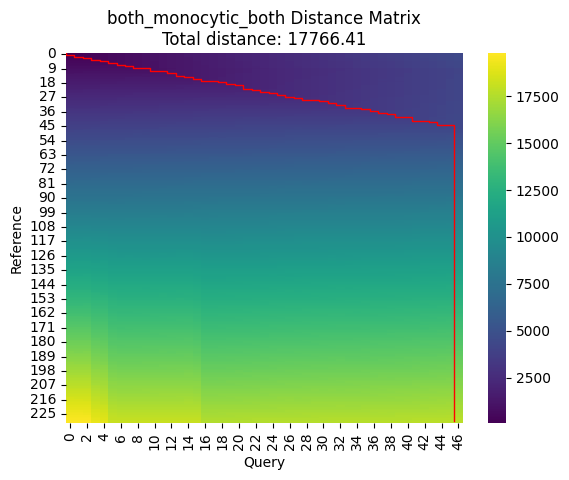

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['both_granulocytic_both_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


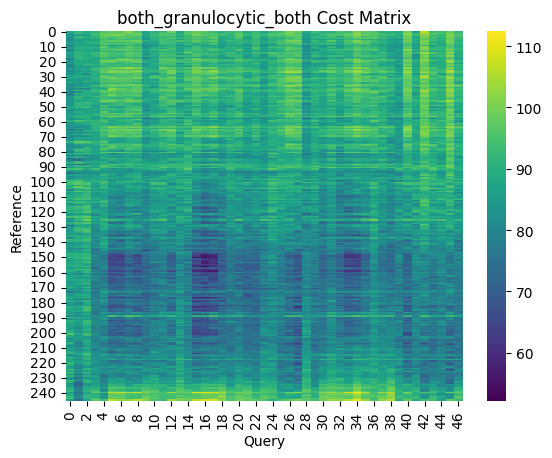

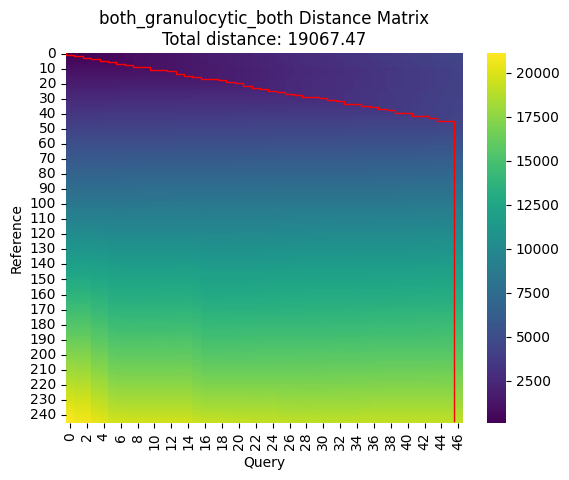

In [56]:
warping_both = dynchro.tl.get_matching_lineages(adata, both, "both", mode="copy", plot = True)

In [ ]:
# These are the final distances for each combination
warping_irf8[2], warping_gfi1[2], warping_both[2]

(array([[1.36832027],
        [1.27322724],
        [1.22021599]]),
 array([[1.07200612],
        [0.96001134],
        [0.96925778]]),
 array([[1.79466405],
        [1.63640179],
        [1.64914978]]))

In [58]:
import pickle
with open("figures/2_dynchro_warpings.pkl", "wb") as f:
    pickle.dump((warping_irf8, warping_gfi1, warping_both), f)

## 2.3 Plot average cost

Here we will plot the average costs over pseudotime for the corresponding warpings, investigate how this changes over pseudotime

In [67]:
gran = warping_irf8[3][2]
irf8_warped = warping_irf8[4][0]
dtw_label = "irf8_granulocytic_irf8"
gran = dynchro.tl.avg_cost_path(gran, dtw_key=dtw_label)
irf8_warped = dynchro.tl.avg_cost_path(irf8_warped, dtw_key=dtw_label)

<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

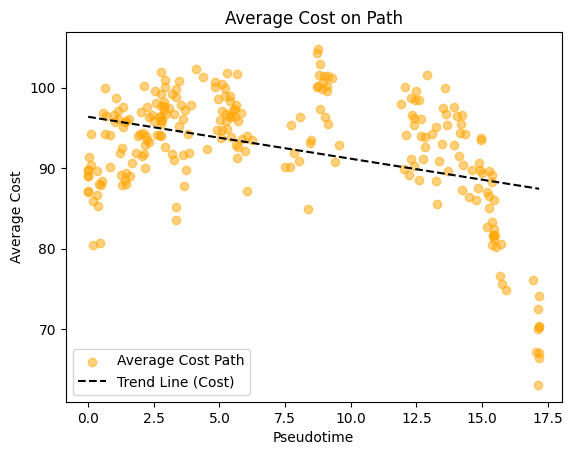

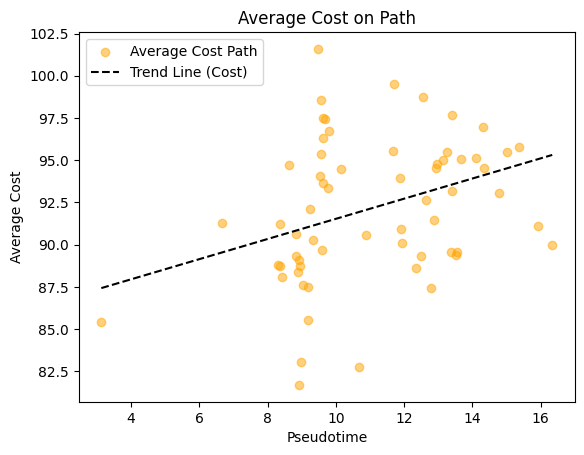

In [87]:
dynchro.pl.plot_avg_cost_path(gran, pseudotime_key="pseudotime", dtw_key=dtw_label)
dynchro.pl.plot_avg_cost_path(irf8_warped, pseudotime_key="pseudotime", dtw_key=dtw_label)

In [88]:
mono = warping_gfi1[3][1]
gfi1_warped = warping_gfi1[4][0]
dtw_label = "gfi1_monocytic_gfi1"
mono = dynchro.tl.avg_cost_path(mono, dtw_key=dtw_label)
gfi1_warped = dynchro.tl.avg_cost_path(gfi1_warped, dtw_key=dtw_label)

<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

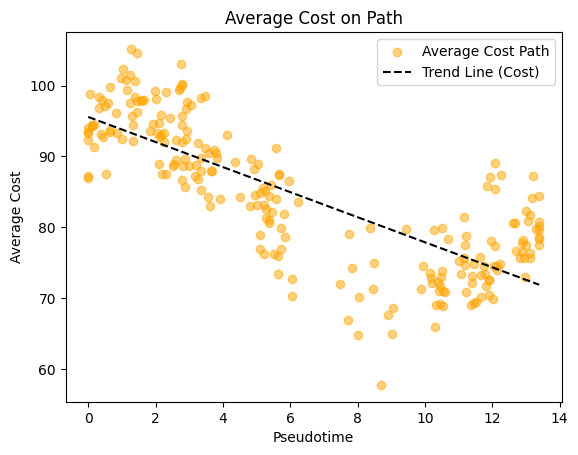

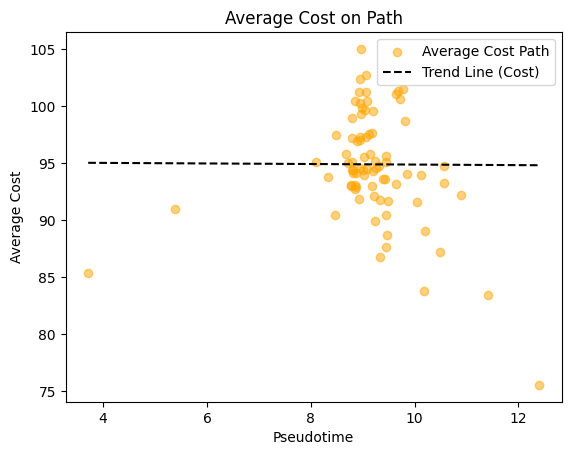

In [89]:
dynchro.pl.plot_avg_cost_path(mono, pseudotime_key="pseudotime", dtw_key=dtw_label)
dynchro.pl.plot_avg_cost_path(gfi1_warped, pseudotime_key="pseudotime", dtw_key=dtw_label)

In [90]:
ery = warping_irf8[3][0]
irf8_warped2 = warping_irf8[4][0]
dtw_label = "irf8_erythrocytic_irf8"
ery = dynchro.tl.avg_cost_path(ery, dtw_key=dtw_label)
irf8_warped2 = dynchro.tl.avg_cost_path(irf8_warped2, dtw_key=dtw_label)

<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

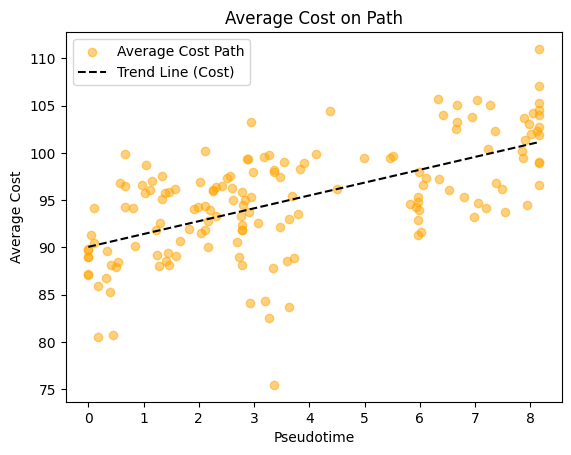

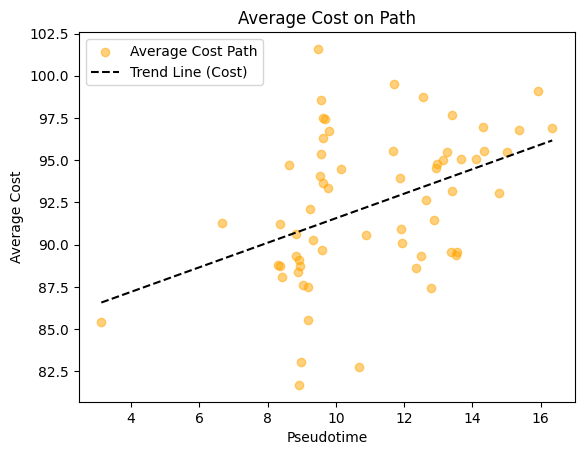

In [91]:
dynchro.pl.plot_avg_cost_path(ery, pseudotime_key="pseudotime", dtw_key=dtw_label)
dynchro.pl.plot_avg_cost_path(irf8_warped2, pseudotime_key="pseudotime", dtw_key=dtw_label)


## 2.4 Plot warping

In [66]:
wt_irf8 = warping_irf8[3][2]

warped_irf8 = warping_irf8[4][0]
erythrocytic = warping_irf8[3][0]
monocytic = warping_irf8[3][1]
granulocytic = warping_irf8[3][2]

In [67]:
import pickle

with open("figures/2_dynchro_warpings_warpedfig_irf8.pkl", "wb") as f:
    pickle.dump([warped_irf8, erythrocytic, monocytic, granulocytic], f)

In [68]:
erythrocytic = warping_irf8[3][0]
monocytic = warping_gfi1[3][1]
granulocytic = warping_irf8[3][2]

In [ ]:
wt_gfi1 = warping_gfi1[3][2]
warped_GFI1 = warping_gfi1[4][0]


In [70]:
with open("figures/2_dynchro_warpings_warpedfig_gfi1.pkl", "wb") as f:
    pickle.dump([warped_GFI1, erythrocytic, monocytic, granulocytic], f)

/home/louise/Work/dynchro/src/dynchro/pl/warping.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds1_x = norm(warped_datasets[0].obs[pseudotime_key])[warping2]
/home/louise/Work/dynchro/src/dynchro/pl/warping.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds2_x = norm(warped_datasets[1].obs[pseudotime_key])[warping1]
/home/louise/Work/dynchro/src/dynchro/pl/warping.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


<Axes: xlabel='Pseudotime'>

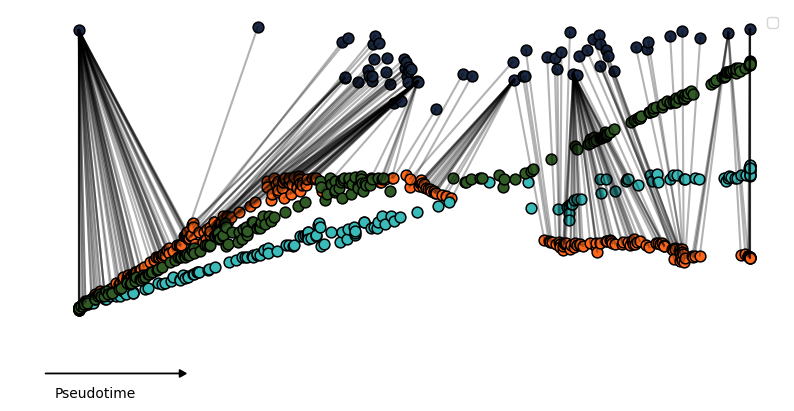

In [23]:
dynchro.pl.plot_warping(
    warped_datasets = [granulocytic, warped_irf8],
    extra_datasets = [erythrocytic, monocytic],
    dtw_key = "irf8_granulocytic_irf8",
    dimred_key = "X_vis_umap"
)

## 2.5 Bootstrap

In [59]:
adata = adata[adata.obs.branch_id_id.isin([0, 1, 3, 4])]
def calculate_distance_irf8(names):
    knockout = irf8[names]
    ri, ci, distances, lin1, lin2 = dynchro.tl.get_matching_lineages(adata, knockout, dtw_key = "irf8")
    return distances[:, 0]

def calculate_distance_gfi1(names):
    knockout = gfi1[names]
    ri, ci, distances, lin1, lin2 = dynchro.tl.get_matching_lineages(adata, knockout, dtw_key = "gfi1")
    return distances[:, 0]

def calculate_distance_both(names):
    knockout = both[names]
    ri, ci, distances, lin1, lin2 = dynchro.tl.get_matching_lineages(adata, knockout, dtw_key = "both")
    return distances[:, 0] 

In [60]:
res_irf8 = stats.bootstrap([irf8.obs_names], calculate_distance_irf8, n_resamples= 100, vectorized=False, axis = 0)
results_irf8 = res_irf8.bootstrap_distribution
res_gfi1 = stats.bootstrap([gfi1.obs_names], calculate_distance_gfi1, n_resamples= 100, vectorized=False, axis = 0)
results_gfi1 = res_gfi1.bootstrap_distribution
res_both = stats.bootstrap([both.obs_names], calculate_distance_both, n_resamples= 100, vectorized=False, axis = 0)
results_both = res_both.bootstrap_distribution

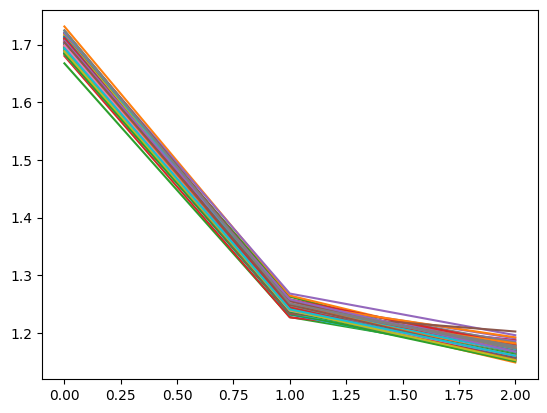

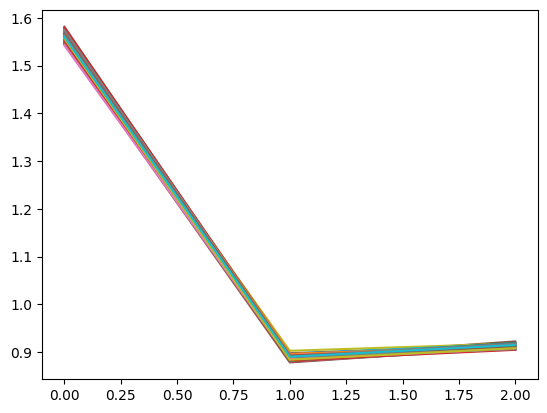

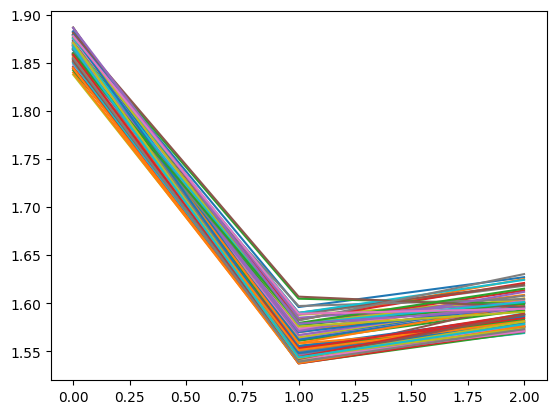

In [61]:
# for each three values, plot a line plot
for i, g, b in zip(results_irf8[0], results_irf8[1], results_irf8[2]):
    plt.plot([i, g, b])

plt.show()

# for each three values, plot a line plot
for i, g, b in zip(results_gfi1[0], results_gfi1[1], results_gfi1[2]):
    plt.plot([i, g, b])

plt.show()
for i, g, b in zip(results_both[0], results_both[1], results_both[2]):
    plt.plot([i, g, b])

In [62]:
# write out res_irf8, res_gfi1, res_both to a pickle file
import pickle
with open("figures/2_dynchro_bootstrap_results.pkl", "wb") as f:
    pickle.dump((res_irf8.bootstrap_distribution, res_gfi1.bootstrap_distribution, res_both.bootstrap_distribution), f)


In [4]:
import pickle
with open("figures/2_dynchro_bootstrap_results.pkl", "rb") as f:
    results_irf8, results_gfi1, results_both = pickle.load(f)

In [6]:
irf8_data = pd.DataFrame({"erythrocytic": results_irf8[0], "monocytic": results_irf8[1], "granulocytic": results_irf8[2], "id": range(len(results_irf8[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
irf8_data = irf8_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
irf8_data

,id,branch,normalised_distance
0,0,erythrocytic,1.698250
1,1,erythrocytic,1.697057
2,2,erythrocytic,1.712452
3,3,erythrocytic,1.706220
4,4,erythrocytic,1.693021
...,...,...,...
295,95,granulocytic,1.157724
296,96,granulocytic,1.160385
297,97,granulocytic,1.172916
298,98,granulocytic,1.152710


In [7]:
gfi1_data = pd.DataFrame({"erythrocytic": results_gfi1[0], "monocytic": results_gfi1[1], "granulocytic": results_gfi1[2], "id": range(len(results_gfi1[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
gfi1_data = gfi1_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
gfi1_data

,id,branch,normalised_distance
0,0,erythrocytic,1.563601
1,1,erythrocytic,1.550573
2,2,erythrocytic,1.551752
3,3,erythrocytic,1.558893
4,4,erythrocytic,1.574136
...,...,...,...
295,95,granulocytic,0.910477
296,96,granulocytic,0.906903
297,97,granulocytic,0.906051
298,98,granulocytic,0.907958


In [8]:
both_data = pd.DataFrame({"erythrocytic": results_both[0], "monocytic": results_both[1], "granulocytic": results_both[2], "id": range(len(results_both[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
both_data = both_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
both_data

,id,branch,normalised_distance
0,0,erythrocytic,1.870054
1,1,erythrocytic,1.865382
2,2,erythrocytic,1.870737
3,3,erythrocytic,1.867193
4,4,erythrocytic,1.875878
...,...,...,...
295,95,granulocytic,1.588254
296,96,granulocytic,1.594378
297,97,granulocytic,1.573169
298,98,granulocytic,1.581054


In [10]:
%load_ext rpy2.ipython

In [12]:
%%R -i irf8_data -i gfi1_data

saveRDS(irf8_data, file = "dynchro_bootstrap_irf8_data.rds")
saveRDS(gfi1_data, file = "dynchro_bootstrap_gfi1_data.rds")


In [312]:
%%R
install.packages("ggstatsplot")

* installing *source* package ‘ggstatsplot’ ...
** this is package ‘ggstatsplot’ version ‘0.13.1’
** package ‘ggstatsplot’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ggstatsplot)


TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

In [319]:
%%R -i gfi1_data
library("ggstatsplot")
library("ggplot2")
p1 <- ggwithinstats(gfi1_data, x = branch, y = normalised_distance, title = "GFI1 knockout", xlab = "Branch", ylab = "Normalised distance",
        boxplot.args = list(width = 0),
        violin.args = list(width = 0)
        )
ggsave("gfi1_knockout.pdf", p1, width = 4.5, height = 4.5, dpi = 300)

In [ ]:
%%R -i both_data
p2 <- ggwithinstats(both_data, x = branch, y = normalised_distance, title = "GFI1 and IRF8 knockout", xlab = "Branch", ylab = "Normalised distance")
ggsave("both_knockout.pdf", p2)

Saving 6.67 x 6.67 in image


In [320]:
%%R -i irf8_data
p3 <- ggwithinstats(
        irf8_data, x = branch, y = normalised_distance, title = "IRF8 knockout", xlab = "Branch", ylab = "Normalised distance",
        boxplot.args = list(width = 0),
        violin.args = list(width = 0)
    )
ggsave("irf8_knockout.pdf", p3, width = 4.5, height = 4.5, dpi = 300)